In [1]:
# Uncomment the line below to install Aer package for custom depolarizing error
# !pip install qiskit-aer

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
import numpy as np
from qiskit.circuit.library import CZGate, RXGate, RYGate, UnitaryGate, TGate, XGate, YGate, CPhaseGate, HGate
from qiskit.quantum_info import Statevector, Operator, average_gate_fidelity, random_clifford, Clifford
import matplotlib.pyplot as plt
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit_aer.noise import depolarizing_error, NoiseModel, thermal_relaxation_error, coherent_unitary_error, kraus_error
from scipy.linalg import sqrtm

# Gate definition

In [2]:
# Define the gates
X90, Y90 = RXGate(np.pi / 2), RYGate(np.pi / 2)
T, X, Y, H = TGate(), XGate(), YGate(), HGate()
W = UnitaryGate((X.to_matrix()+Y.to_matrix())/np.sqrt(2), label='w')
SW = UnitaryGate(sqrtm(W.to_matrix()), label='sw')
XY90 = UnitaryGate((X90.to_matrix() + Y90.to_matrix()) / np.sqrt(3), label="XY90")
XY90mm = UnitaryGate((-X90.to_matrix() - Y90.to_matrix()) / np.sqrt(3), label="XY90mm")
XY90pm = UnitaryGate((X90.to_matrix() - Y90.to_matrix()), label="XY90pm")
XY90mp = UnitaryGate((-X90.to_matrix() + Y90.to_matrix()), label="XY90mp")
# CZ, CP = CZGate(), CPhaseGate(np.pi/2)
CZ = CPhaseGate(np.pi*1)

# Possible gate sets
gate_dict1 = {0: X90, 1: Y90, 2: T}  # https://arxiv.org/abs/1608.00263
gate_dict2 = {0: X90, 1: Y90, 2: SW}  # https://www.nature.com/articles/s41586-019-1666-5
gate_dict3 = {0: X90, 1: Y90, 2: XY90, 3: XY90mm, 4: XY90pm, 5: XY90mp} # https://arxiv.org/abs/2001.08343
gate_dict4 = {0: X90, 1: Y90, 2: XY90} 
gate_sets = [gate_dict1, gate_dict2, gate_dict3, gate_dict4]
# Set for storing unique Cliffords
cliffords = []

# Generate Cliffords until we have 24 unique ones
while len(cliffords) < 24:
    # Generate a random Clifford
    c = random_clifford(1)
    # Add it to the set (this automatically checks for uniqueness)
    if c not in cliffords:
        cliffords.append(c)

# Convert set to list
cliffords = {i: c for i, c in enumerate(cliffords)}
gate_sets.append(cliffords)

# Now cliffords list contains all 24 one-qubit Clifford operators


In [3]:
# Choose the gate set
gate_set_choice = 1 # 1, 2, 3 or 4
gate_dict = gate_sets[gate_set_choice - 1]
random_gates = len(gate_dict)
print(random_gates)

3


# Noise parameters

In [4]:
num_qubits = 1  # Number of qubits
apply_CZ = True  # Apply CZ gate
error1q = 0.07
error2q = 0.03
effective_error = error2q + num_qubits*error1q if num_qubits == 2 and apply_CZ else num_qubits*error1q
depol_error1q = depolarizing_error(error1q, 1)
depol_error2q = depolarizing_error(error2q, 2)
sq_gate_set = ["t", "rx", "ry", "u1", "u2", "u3"]
noise_model = NoiseModel(basis_gates = sq_gate_set)
noise_model = NoiseModel()
if num_qubits == 2:
    noise_model.add_all_qubit_quantum_error(depol_error2q, ["cz"])
# noise_model.add_all_qubit_quantum_error(depol_error1q, sq_gate_set)
noise_model.add_all_qubit_quantum_error(depol_error1q, ['rz', 'sx', 'x'])
backend = AerSimulator(noise_model=noise_model, method="density_matrix", basis_gates=noise_model.basis_gates) 
print(noise_model.noise_qubits)
print(noise_model)

[]
NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['rz', 'x', 'sx']
  All-qubits errors: ['rz', 'sx', 'x']


# Sequence parameters

In [5]:
# np.random.seed(335)
sequences = 30 # Number of sequences
max_depth = 50# Maximum depth
step = 1 # Step for depths to be tested
n_avgs = 1000 # Number of shots
np.random.seed(13111)
dim = 2 ** num_qubits
qubits = QuantumRegister(num_qubits, "q") # Number of qubits

depths = np.arange(1, max_depth + 1, step) # Depths to be tested
sq_gates, counts_list, states_list, circuits_list = [], [], [], []  # 2D for 2 qubits


# Generate random sequences

In [6]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Gate

def depolarizing_channel(qc: QuantumCircuit, qubit: int, p: float):
    """Apply depolarizing channel to a qubit in a quantum circuit.

    Args:
        qc: QuantumCircuit to apply the channel to.
        qubit: Index of the qubit the channel is applied to.
        p: Depolarizing probability.
    """
    # Randomly choose an operation
    probs = [1-p, p/3, p/3, p/3]
    op = np.random.choice(4, p=probs)

    # Apply the operation
    if op == 0:
        qc.id(qubit)
    elif op == 1:
        qc.x(qubit)
    elif op == 2:
        qc.y(qubit)
    else:
        qc.z(qubit)  # Identity operation

def bit_flip_channel(qc: QuantumCircuit, qubit: int, p: float):
    """Apply depolarizing channel to a qubit in a quantum circuit.

    Args:
        qc: QuantumCircuit to apply the channel to.
        qubit: Index of the qubit the channel is applied to.
        p: Depolarizing probability.
    """
    # Randomly choose an operation
    probs = [1-p, p]
    op = np.random.choice(2, p=probs)

    # Apply the operation
    if op == 0:
        qc.id(qubit)
    elif op == 1:
        qc.x(qubit)

def phase_flip_channel(qc: QuantumCircuit, qubit: int, p: float):
    """Apply depolarizing channel to a qubit in a quantum circuit.

    Args:
        qc: QuantumCircuit to apply the channel to.
        qubit: Index of the qubit the channel is applied to.
        p: Depolarizing probability.
    """
    # Randomly choose an operation
    probs = [1-p, p]
    op = np.random.choice(2, p=probs)

    # Apply the operation
    if op == 0:
        qc.id(qubit)
    elif op == 1:
        qc.z(qubit)

In [7]:

# Generate sequences
for s in range(sequences):  # For each sequence
    counts_list.append([])
    sq_gates.append([])
    circuits_list.append([])
    states_list.append([])
    for i, d in enumerate(depths):  # For each maximum depth
        sq_gates[s].append(np.zeros((2, d), dtype=int))
        for q in range(num_qubits):  # For each qubit
            # Generate random single qubit gates
            # Start the sequence with a random gate
            sq_gates[s][i][q][0] = np.random.randint(random_gates)
        for d_ in range(1, d):  # For each growing depth (all cycles until maximum depth d)
            for q in range(num_qubits):  # For each qubit
                sq_gates[s][i][q][d_] = np.random.randint(random_gates)
                # Make sure that the same gate is not applied twice in a row
                while sq_gates[s][i][q][d_] == sq_gates[s][i][q][d_ - 1]:
                    sq_gates[s][i][q][d_] = np.random.randint(random_gates)
        # Define the circuit
        qc = QuantumCircuit(qubits)
        # First cycle: apply Hadamard 
        for q in range(num_qubits):
            qc.append(H, [q])
        if num_qubits == 2 and apply_CZ:
            qc.append(CZ, qubits)
        for d_ in range(d):  # Apply layers
            for q in range(num_qubits):  # For each qubit, append single qubit gates
                qc.append(gate_dict[sq_gates[s][i][q][d_]], [qubits[q]])
                # depolarizing_channel(qc, q, error1q)
                # bit_flip_channel(qc, q, error1q)
                # phase_flip_channel(qc, q, error1q)
            # Apply CZ gate
            if num_qubits == 2 and apply_CZ:
                qc.append(CZ, qubits)
        # Store the statevector
        qc.save_density_matrix()
        # states_list[s].append(Statevector(qc))
        circuits_list[s].append(qc)
        

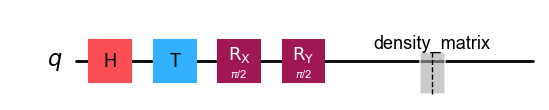

In [8]:
# Draw the circuit of your choice: first index is the sequence, second index is the depth index in depths array
circuits_list[1][2].draw(output="mpl")

# Execute the circuits

In [9]:
# Execute circuit (transpiled) and store counts
circ_list = [circuits_list[s][i].measure_all(inplace=False) for s in range(sequences) for i in range(len(depths))]
transpiled_circs = transpile(circ_list, backend)
job = backend.run(transpiled_circs, shots=n_avgs)
counts = job.result().get_counts()

In [10]:

dms = [job.result().data(i)["density_matrix"] for i in range(len(transpiled_circs))]
purities = [dm.purity() for dm in dms]
# Add missing keys to counts (Qiskit does not add all possible outcomes by default, only the ones carrying actual counts)
for count in counts:
    for key in [bin(i)[2:].zfill(num_qubits) for i in range(dim)]:
        if key not in count.keys():
            count[key] = 0
# Add counts to list
idx = 0
for s in range(sequences):
    for i in range(len(depths)): 
        counts_list[s].append(counts[idx])
        idx += 1


In [12]:
purities

[(0.8234950917245003+0j),
 (0.8234950917245001+0j),
 (0.7419911535896471-1.659350947341709e-17j),
 (0.7419911535896471+0j),
 (0.7419911535896471+0j),
 (0.8740260050000003+0j),
 (0.7419911535896473+0j),
 (0.8234950917245003-1.578643574736883e-17j),
 (0.7419911535896471-2.5531939731519044e-17j),
 (0.8234950917245003+0j),
 (0.7419911535896471+0j),
 (0.7797909048325204-1.3653688277899288e-17j),
 (0.7419911535896472+0j),
 (0.7419911535896471+0j),
 (0.7419911535896473-1.4435500082204274e-17j),
 (0.7419911535896471+0j),
 (0.7419911535896471+0j),
 (0.7419911535896471+0j),
 (0.7419911535896468+5.119268490888362e-18j),
 (0.7419911535896472+0j),
 (0.741991153589647+0j),
 (0.7419911535896471+0j),
 (0.7419911535896471+0j),
 (0.7419911535896468+0j),
 (0.741991153589647-5.695955702597945e-18j),
 (0.7419911535896468+0j),
 (0.7419911535896468+0j),
 (0.7419911535896471+1.6759053157295267e-17j),
 (0.7419911535896466+0j),
 (0.7419911535896468-9.133648073317016e-18j),
 (0.8234950917245003+0j),
 (0.74199115

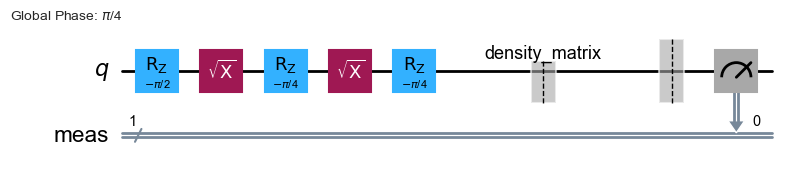

In [13]:
transpiled_circs[2].draw(output="mpl")

# Post-processing

In [19]:
def cross_entropy(p, q, epsilon=1e-15):
    """
    Calculate cross entropy between two probability distributions.

    Parameters:
    - p: numpy array, the true probability distribution
    - q: numpy array, the predicted probability distribution
    - epsilon: small value to avoid taking the logarithm of zero

    Returns:
    - Cross entropy between p and q
    """
    q = np.maximum(q, epsilon)  # Avoid taking the logarithm of zero

    # print(f"p: {p}, \nq: {q}")

    x_entropy = -np.sum(p * np.log(q))

    return x_entropy

In [20]:
from scipy.optimize import curve_fit
# Post-processing
records = []
incoherent_dist = np.ones(dim) / dim
fidelities = np.zeros((sequences, len(depths)))
expected_probs = np.zeros((sequences, len(depths), dim))
measured_probs = np.zeros((sequences, len(depths), dim))
linear_fidelities = np.zeros((sequences, len(depths)))
noise_model_fidelities = np.zeros((sequences, len(depths)))

# Reconstruct sequence from gate indices (similar step to what is done in QUA)
for s in range(sequences):
    for j, d in enumerate(depths):
        qc = QuantumCircuit(qubits)
        for q in range(num_qubits):
            qc.append(H, [q])
        if num_qubits == 2 and apply_CZ:
            qc.append(CZ, qubits)
        for k in range(d):
            sq_gates1 = [gate_dict[sq_gates[s][j][q][k]] for q in range(num_qubits)]
            # Retrieve random single qubit gates applied on both qubits
            # Apply the gates on the state
            for q, sq_gate in enumerate(sq_gates1):
                qc.append(sq_gate, [q])
            if num_qubits == 2 and apply_CZ:
                qc.append(CZ, [0, 1])
            # print("computed state: %s" % state)
        expected_probs[s, j] = Statevector(qc).probabilities()
        measured_probs[s, j] = (
            np.array([counts_list[s][j][bin(i)[2:].zfill(num_qubits)] for i in range(dim)])
            / n_avgs
        )
        xe_incoherent = cross_entropy(incoherent_dist, expected_probs[s, j])
        xe_measured = cross_entropy(measured_probs[s, j], expected_probs[s, j])
        xe_expected = cross_entropy(expected_probs[s, j], expected_probs[s, j])
        
        f_log_xeb = (xe_incoherent - xe_measured) / (xe_incoherent - xe_expected)
        f_linear_xeb = np.sum(measured_probs[s, j] * (dim *  expected_probs[s, j] -1))
        fidelities[s, j] = f_log_xeb
        linear_fidelities[s, j] = f_linear_xeb
        noise_model_fidelities[s, j] = (1-effective_error)**d
        
        # print(f"seq {s + 1}, depth {depths[j]}: f_xeb = {f_xeb}")
        
        records += [
            {
                "sequence": s,
                "depth": depths[j],
                "pure_probs": expected_probs[s, j],
                # "pure_probs": states_list[s][j].probabilities(),
                "sampled_probs": measured_probs[s, j],
                "circuit": circuits_list[s][j],
            }
        ]

Fxeb = np.mean(fidelities, axis=0)
Flinear = np.mean(linear_fidelities, axis=0)
Fnoise = np.mean(noise_model_fidelities, axis=0)
for record in records:
    e_u = np.sum(record["pure_probs"] ** 2)
    u_u = np.sum(record["pure_probs"]) / dim
    m_u = np.sum(record["pure_probs"] * record["sampled_probs"])
    record.update(e_u=e_u, u_u=u_u, m_u=m_u)

# State Heatmap

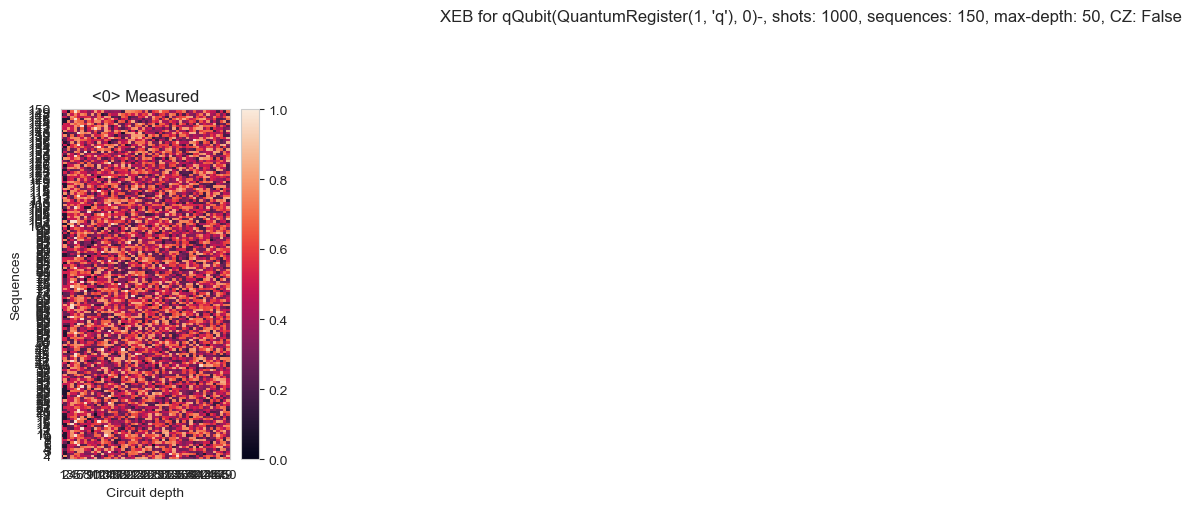

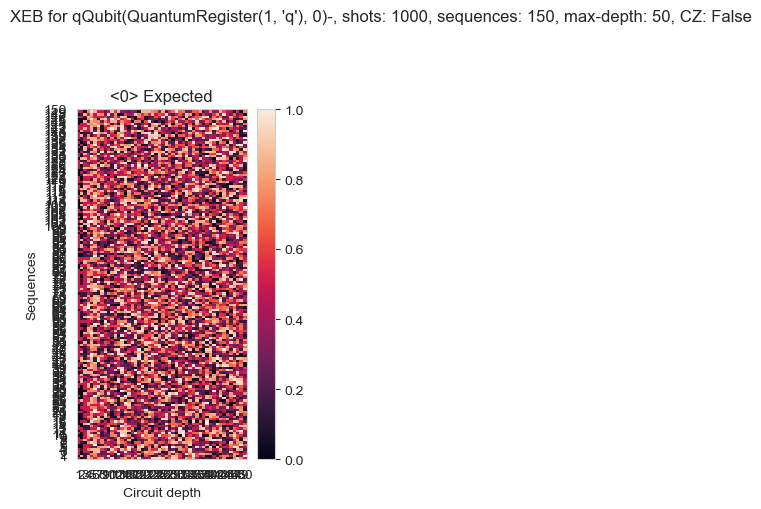

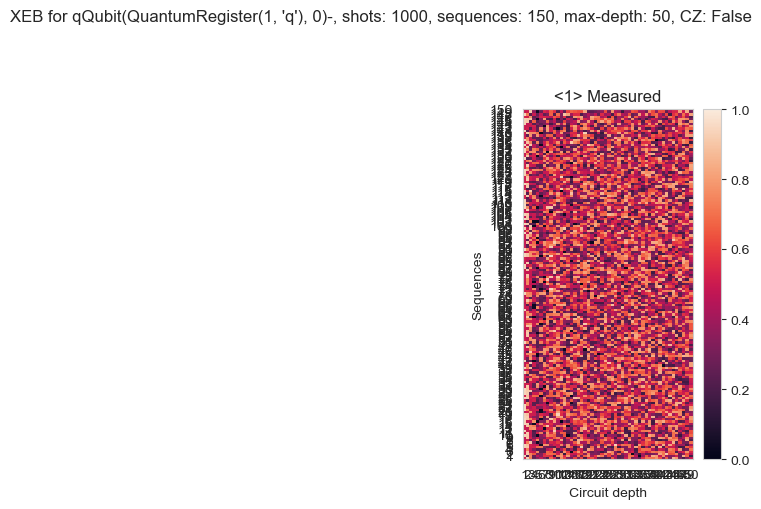

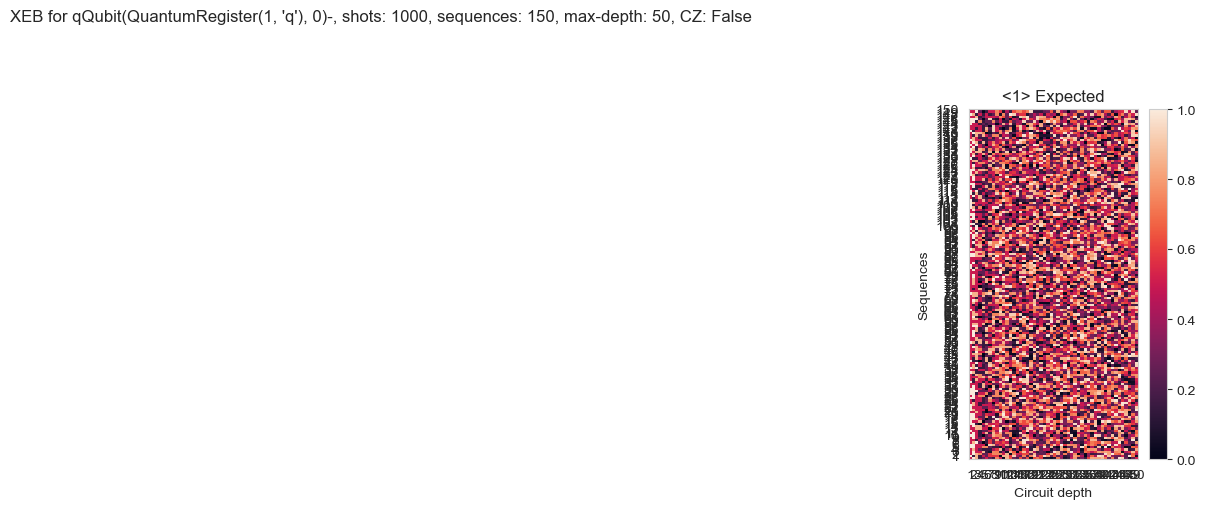

In [21]:
# Plot the results
def create_subplot(data, subplot_number, title):
    plt.subplot(subplot_number)
    plt.pcolor(depths, range(sequences), np.abs(data), vmin=0., vmax=1.0)
    ax = plt.gca()
    ax.set_title(title)
    ax.set_xlabel("Circuit depth")
    ax.set_ylabel("Sequences")
    ax.set_xticks(depths)
    ax.set_yticks(np.arange(1, sequences + 1))
    plt.colorbar()

titles, data = [], []

for i in range(dim):
    titles.append(f"<{bin(i)[2:].zfill(num_qubits)}> Measured")
    titles.append(f"<{bin(i)[2:].zfill(num_qubits)}> Expected")
    data.append(measured_probs[:, :, i])
    data.append(expected_probs[:, :, i])

plot_number = [241, 242, 243, 244, 245, 246, 247, 248]

k = 0
for title, d, n in zip(titles, data, plot_number):
    plt.figure(figsize=(20, 10))
    qubits_involved = ""
    for q in qubits:
        qubits_involved += f"q{q}-"
    plt.suptitle(f"XEB for "+ qubits_involved+f", shots: {n_avgs}, sequences: {sequences}, max-depth: {max_depth}, CZ: {True if num_qubits == 2 else False}")
    create_subplot(d, n, title)
    plt.subplots_adjust(wspace=1.1)
    k+=1


In [22]:
import pandas as pd
df = pd.DataFrame(records)
df["y"] = df["m_u"] - df["u_u"]
df["x"] = df["e_u"] - df["u_u"]

df["numerator"] = df["x"] * df["y"]
df["denominator"] = df["x"] ** 2
df

sequence  depth                                   pure_probs  \
0            0      1     [0.4999999999999999, 0.4999999999999999]   
1            0      2  [9.244463733058728e-33, 0.9999999999999996]   
2            0      3    [0.14644660940672616, 0.8535533905932733]   
3            0      4    [0.8535533905932733, 0.14644660940672616]   
4            0      5    [0.7499999999999996, 0.24999999999999994]   
...        ...    ...                                          ...   
7495       149     46      [0.446720272239104, 0.5532797277608935]   
7496       149     47    [0.05001578323088512, 0.9499842167691127]   
7497       149     48    [0.5263285756647552, 0.47367142433524234]   
7498       149     49   [0.025204190567372945, 0.9747958094326257]   
7499       149     50     [0.7432979345603957, 0.2567020654396009]   

       sampled_probs  \
0     [0.478, 0.522]   
1     [0.081, 0.919]   
2     [0.271, 0.729]   
3     [0.754, 0.246]   
4     [0.662, 0.338]   
...              ...   
7495  [0.462, 0.538]   
7496  [0.191, 0.809]   
7497  [0.501, 0.499]   
7498  [0.162, 0.838]   
7499  [0.692, 0.308]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

/var/folders/y8/9zgwllj55dbbch4pxmg_g7jm0000gn/T/ipykernel_16117/3230279464.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fids = df.groupby("depth").apply(per_cycle_depth).reset_index()


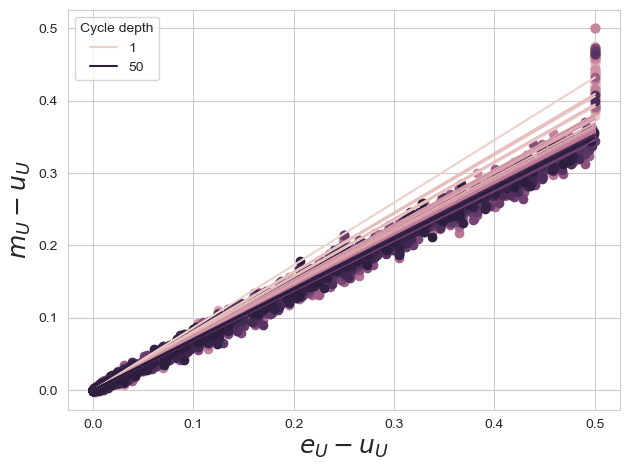

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt

# Color by cycle depth
import seaborn as sns

colors = sns.cubehelix_palette(n_colors=len(depths))
colors = {k: colors[i] for i, k in enumerate(depths)}

_lines = []


def per_cycle_depth(df):
    fid_lsq = df["numerator"].sum() / df["denominator"].sum()

    cycle_depth = df.name
    xx = np.linspace(0, df["x"].max())
    (l,) = plt.plot(xx, fid_lsq * xx, color=colors[cycle_depth])
    plt.scatter(df["x"], df["y"], color=colors[cycle_depth])

    global _lines
    _lines += [l]  # for legend
    return pd.Series({"fidelity": fid_lsq})


fids = df.groupby("depth").apply(per_cycle_depth).reset_index()
plt.xlabel(r"$e_U - u_U$", fontsize=18)
plt.ylabel(r"$m_U - u_U$", fontsize=18)
_lines = np.asarray(_lines)
plt.legend(_lines[[0, -1]], depths[[0, -1]], loc="best", title="Cycle depth")
plt.tight_layout()

# Fidelity plot

In [ ]:
from typing import Tuple
from scipy import optimize
from scipy import stats


# Fit the data
def exponential_decay(cycle_depths: np.ndarray, a: float, layer_fid: float) -> np.ndarray:
    """An exponential decay for fitting.

    This computes `a * layer_fid**cycle_depths`

    Args:
        cycle_depths: The various depths at which fidelity was estimated. This is the independent
            variable in the exponential function.
        a: A scale parameter in the exponential function.
        layer_fid: The base of the exponent in the exponential function.
    """
    return a * layer_fid**cycle_depths

def _fit_exponential_decay(
    cycle_depths: np.ndarray, fidelities: np.ndarray
) -> Tuple[float, float, float, float]:
    """Fit an exponential model fidelity = a * layer_fid**x using nonlinear least squares.

    This uses `exponential_decay` as the function to fit with parameters `a` and `layer_fid`.

    Args:
        cycle_depths: The various depths at which fidelity was estimated. Each element is `x`
            in the fit expression.
        fidelities: The estimated fidelities for each cycle depth. Each element is `fidelity`
            in the fit expression.

    Returns:
        a: The first fit parameter that scales the exponential function, perhaps accounting for
            state prep and measurement (SPAM) error.
        layer_fid: The second fit parameters which serves as the base of the exponential.
        a_std: The standard deviation of the `a` parameter estimate.
        layer_fid_std: The standard deviation of the `layer_fid` parameter estimate.
    """
    cycle_depths = np.asarray(cycle_depths)
    fidelities = np.asarray(fidelities)

    # Get initial guess by linear least squares with logarithm of model.
    # This only works for positive fidelities. We use numpy fancy indexing
    # with `positives` (an ndarray of bools).
    positives = fidelities > 0
    if np.sum(positives) <= 1:
        # The sum of the boolean array is the number of `True` entries.
        # For one or fewer positive values, we cannot perform the linear fit.
        return 0, 0, np.inf, np.inf
    cycle_depths_pos = cycle_depths[positives]
    log_fidelities = np.log(fidelities[positives])

    slope, intercept, _, _, _ = stats.linregress(cycle_depths_pos, log_fidelities)
    layer_fid_0 = np.clip(np.exp(slope), 0, 1)
    a_0 = np.clip(np.exp(intercept), 0, 1)

    try:
        (a, layer_fid), pcov = optimize.curve_fit(
            exponential_decay,
            cycle_depths,
            fidelities,
            p0=(a_0, layer_fid_0),
            bounds=((0, 0), (1, 1)),
        )
    except ValueError:  # pragma: no cover
        return 0, 0, np.inf, np.inf

    a_std, layer_fid_std = np.sqrt(np.diag(pcov))
    return a, layer_fid, a_std, layer_fid_std

fit_google = True
fit_log_entropy = True
xx = np.linspace(0, fids["depth"].max())
# In XEB, we extract the depolarizing fidelity, which is
# related to (but not equal to) the Pauli error.
# For the latter, an error involves doing X, Y, or Z with E_PAULI/3
# but for the former, an error involves doing I, X, Y, or Z with e_depol/4
try:
    a, layer_fid, a_std, layer_fid_std = _fit_exponential_decay(fids["depth"], fids["fidelity"])
    plt.plot(xx, exponential_decay(xx, a, layer_fid),
         label='Fit (Google processing), layer fidelity={:.2f}'.format(layer_fid),
         color='red')
except:
    print("Fit for Google processing data failed")
    fit_google = False

try:
    a2, layer_fid2, a_std2, layer_fid_std2 = _fit_exponential_decay(depths[1:], Fxeb[1:])

except:
    print("Fit for Log-entropy processing data failed")
    fit_log_entropy = False
    
    
plt.plot(fids["depth"], fids["fidelity"], marker="o", color= 'red', label="Google processing")

# plt.scatter(depths, Fxeb, marker = 'o',
#             color='green', label="Log-entropy processing")
# plt.plot(xx[1:], exponential_decay(xx[1:], a2, layer_fid2),
#         label="Fit (Log-entropy processing), layer fidelity={:.2f}".format(layer_fid),
#         color="green")
# plt.plot(depths, Flinear, marker="o", color="blue", label="Linear XEB")
plt.plot(depths, Fnoise, marker="o", color="black", label="Noise model")
plt.ylabel("Circuit fidelity", fontsize=20)
plt.xlabel("Cycle Depth $d$", fontsize=20)
plt.title(f"XEB Fidelity (depol error: {effective_error})")
plt.legend(loc="best")
# plt.yscale("log")
plt.tight_layout()
plt.show()

In [25]:
if fit_google:
    print("Google processing fit:")
    print("Params: ", a, layer_fid)
    print("Error per cycle: ", layer_fid)
if fit_log_entropy:
    print("Log-entropy processing fit:")
    print("Params: ", a2, layer_fid2)
    print("Error per cycle: ", layer_fid2)

Google processing fit:
Params:  0.7708762595807097 0.9972927246306571
Error per cycle:  0.9972927246306571
Log-entropy processing fit:
Params:  0.6435520939990315 0.9999999999999999
Error per cycle:  0.9999999999999999


In [ ]:
print(f"Currently used in the QM XEB example:\n {Fxeb}") # Derived from the fSim paper
print(f'Linear XEB of Google:\n {fids["fidelity"]}') # from Google's Supremacy paper

In [ ]:
print("absolute difference", np.abs(fids["fidelity"] - Fxeb))

In [ ]:
plt.title("Relative difference between Google and derived XEB fidelities")
plt.plot(depths, (fids["fidelity"]-Fxeb)/Fxeb, 'o', label="XEB fidelity")


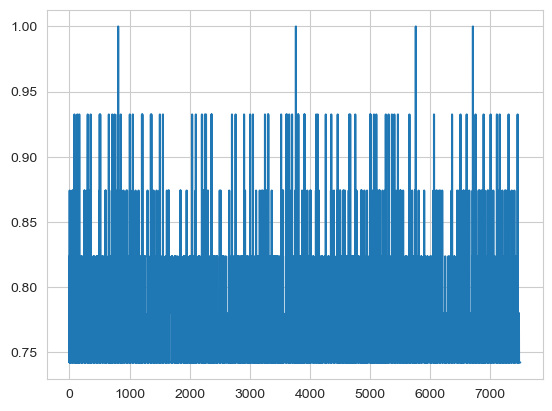

In [11]:
plt.plot(np.real(purities))

In [13]:
# Add counts to list
idx = 0
purities_array = []
for s in range(sequences):
    purities_array.append([])
    for i in range(len(depths)): 
        purities_array[s].append(purities[idx])
        idx += 1

In [14]:
averaged_purities = np.mean(purities_array, axis=0)


/Users/arthurostrauss/anaconda3/envs/rl_qoc_v1/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/arthurostrauss/anaconda3/envs/rl_qoc_v1/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


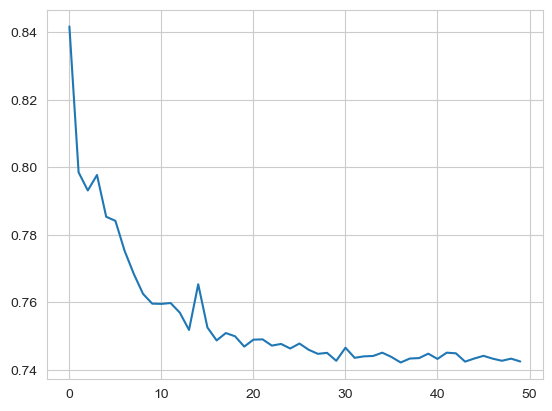

In [15]:
plt.plot(averaged_purities)

In [16]:
purities_array = np.array(purities_array)

In [18]:
purities_array

array([[0.82349509+0.00000000e+00j, 0.82349509+0.00000000e+00j,
        0.74199115-1.65935095e-17j, ..., 0.74199115+0.00000000e+00j,
        0.74199115-2.14633395e-17j, 0.74199115+0.00000000e+00j],
       [0.87402601+0.00000000e+00j, 0.7797909 +0.00000000e+00j,
        0.7797909 +0.00000000e+00j, ..., 0.74199115+4.35799854e-18j,
        0.74199115+0.00000000e+00j, 0.74199115+0.00000000e+00j],
       [0.82349509+0.00000000e+00j, 0.82349509+0.00000000e+00j,
        0.7797909 +0.00000000e+00j, ..., 0.74199115+0.00000000e+00j,
        0.74199115+0.00000000e+00j, 0.74199115+0.00000000e+00j],
       ...,
       [0.82349509+0.00000000e+00j, 0.82349509+0.00000000e+00j,
        0.7797909 +0.00000000e+00j, ..., 0.74199115+0.00000000e+00j,
        0.74199115+1.52483894e-17j, 0.74199115+0.00000000e+00j],
       [0.87402601+0.00000000e+00j, 0.74199115+0.00000000e+00j,
        0.7797909 -1.46813852e-17j, ..., 0.74199115+0.00000000e+00j,
        0.74199115+0.00000000e+00j, 0.74199115+0.00000000e+00j]